In [2]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
%matplotlib inline
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2

# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean*2      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'text.fontsize': 14,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
from measurement_model import measurement_model
from precip_model import precip_model
from GLD_file_tools import GLD_file_tools
from coordinate_structure import transform_coords
import datetime as dt


# m = measurement_model(database = "database_dicts.pkl", GLD_root = 'GLD_root', multiple_bands = False)

p = precip_model(database="database_dicts.pkl",multiple_bands = False)
gld = GLD_file_tools('GLD_mount',prefix='GLD')

td = dt.timedelta(seconds = 10)

# Output grid space:
out_lat_grid = np.arange(-90, 89, step=1)
out_lon_grid = np.arange(-180,179,step=1)

out_grid = np.meshgrid(out_lat_grid, out_lon_grid)

print np.shape(out_grid)

T_STEP = p.db[p.db.keys()[0]]['RES_DT']
T_MAX  = p.db[p.db.keys()[0]]['RES_FINT']
NUM_STEPS = np.round(T_MAX/T_STEP)


in_time_str = "2015-11-01T12:45:00"
in_time = dt.datetime.strptime(in_time_str,  "%Y-%m-%dT%H:%M:%S")

time_sampling_vector = np.linspace(-T_MAX,0,NUM_STEPS)

lat_ind = 7
lon_ind = 8
mag_ind = 9

flashes, flash_times = gld.load_flashes(in_time, td)
if flashes is None:
    print "No flashes found at ", in_time
else:
    print np.shape(flashes)

flashes = flashes[:,(lat_ind, lon_ind, mag_ind, mag_ind)]
flash_coords = transform_coords(flashes[:,0], flashes[:,1], np.zeros_like(flashes[:,0]), 'geographic', 'geomagnetic')
flashes[:,:2] = flash_coords[:,:2]
flashes[:,3] = [(in_time - s).microseconds*1e-6 + (in_time - s).seconds for s in flash_times]


# Mask out flashes outside the range of the interpolator:
mask = (  (np.abs(flashes[:,0]) > 10) 
        & (np.abs(flashes[:,0]) < 60)) 
        # (flashes[:,2] > 50))

# Mask out flashes not of interest to the satellite:
# atten_factors = longitude_scaling(flash_coords, sat.coords)
# mask = atten_factors < 24

print "%g flashes (post-filter)" % np.sum(mask)

masked_flashes = flashes[mask, :]    
    
    


# flux = 0
flux = np.zeros(np.shape(out_grid)[1:])
# for lati, lat in enumerate(out_lat_grid):
#     for loni, lon in enumerate(out_lon_grid):
# for f in flashes:
    #print td.seconds - f[3]   
#     flux += np.sum( p.get_precip_at(f[0], lat, time_sampling_vector + f[3]) *
#                       p.get_longitude_scaling(f[0], f[1], lon, I0=f[2]) * T_STEP )

in_lat = 40
in_lon = 0
in_del = 10
lat_vec = np.zeros_like(out_lat_grid)

for f in masked_flashes:
    # Get interpolated lat grid 
    for lati, lat in enumerate(out_lat_grid):
        lat_vec[lati] = np.sum(p.get_precip_at(f[0], lat, time_sampling_vector + f[3]))

    lon_vec = p.get_longitude_scaling(f[0],f[1], out_lon_grid, I0 = f[2])
    flux += np.outer(lon_vec, lat_vec)

    
print "max flux:", np.max(flux)
    

(2, 359, 179)
(913, 10)
596 flashes (post-filter)
max flux: 0.697814399493


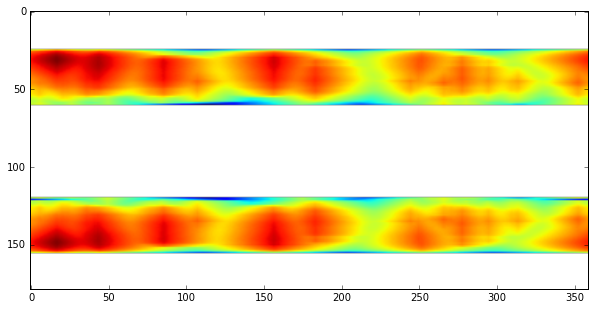

In [101]:
# T_STEP = p.db[p.db.keys()[0]]['RES_DT']
# T_MAX  = p.db[p.db.keys()[0]]['RES_FINT']
# print RES_DT
# print T_MAX

plt.figure()
plt.imshow(np.log10(flux.T))


In [102]:
tt=30

tmask = (masked_flashes[:,3] + grid_time[tt] > 0 ) & (masked_flashes[:,3] + grid_time[tt] < 1)
print masked_flashes[tmask,3]
plt.pcolor(grid_lons, grid_lats, np.log10(N_grid[:,:,tt].T))
plt.clim([-12,0])
plt.pcolor(grid_lons, -1*np.flipud(grid_lats), np.fliplr(np.log10(S_grid[:,:,tt])).T)
plt.clim([-12,0])
plt.colorbar()
plt.scatter(masked_flashes[tmask,1], masked_flashes[tmask,0],marker='.')
plt.scatter(sat.coords.lon(), sat.coords.lat(),marker='x',color='red')
#plt.scatter(masked_coords.lon(), masked_coords.lat())
#plt.clim([-12,0])
plt.show() 

# for tt in grid_time:
#     plt.pcolor(grid_lons, grid_lats, np.log10(N_grid[:,:,tt].T))
#     plt.clim([-8,4])
#     plt.show()

NameError: name 'masked_flashes' is not defined

In [354]:
from build_database import build_database
from load_sim_constants import load_sim_constants
from load_phi_files import load_phi_files

old_dir = '/Users/austin/FUSE/shared/users/asousa/WIPP/WIPPv3/outputs/probably/run_sat/'

# sc = load_sim_constants(os.path.join(old_dir,'codesrc/consts.h'),old_format=True)

# N, S, L = load_phi_files(old_dir + "in_45", sc)

# print "max N:", np.max(N)
# print "min N:", np.min(N)

# print np.shape(N)

build_database(input_dir = old_dir, output_filename = "db_test.pkl",old_format = True, t_new_step=0.5, num_L = 33)



failed: sc.D2R = PI/180.0
failed: sc.R2D = 180.0/PI
failed: sc.MU0 = PI*4E-7
failed: sc.E_EXP_BOT = log10(E_MIN)
failed: sc.E_EXP_TOP = log10(E_MAX)
failed: sc.DE_EXP = ((E_EXP_TOP
failed: sc.NUMLATS = ((EALimN
in lats: [10 15 20 25 30 35 40 45 50 55 60 65]
N NaNs: 0
S NaNs: 0
N NaNs: 0
S NaNs: 0
N NaNs: 0
S NaNs: 0
N NaNs: 0
S NaNs: 0
N NaNs: 0
S NaNs: 0
N NaNs: 0
S NaNs: 0
N NaNs: 0
S NaNs: 0
N NaNs: 0
S NaNs: 0
N NaNs: 0
S NaNs: 0
N NaNs: 0
S NaNs: 0
N NaNs: 0
S NaNs: 0
N NaNs: 0
S NaNs: 0
Saving database


[10 15 20 25 30 35 40 45 50 55 60 65]
N ranges:  0.0 185.874816746
N ranges:  0.0 310.470511388
N ranges:  0.0 1046.39036491
N ranges:  0.0 1312.18410417
N ranges:  0.0 4494.08319715
N ranges:  0.0 16757.5763465
N ranges:  0.0 64962.9059122
N ranges:  0.0 109105.273357
N ranges:  0.0 67566.7250538
N ranges:  0.0 33569.6719426
N ranges:  0.0 4237.51530653
N ranges:  0.0 5548.37534101


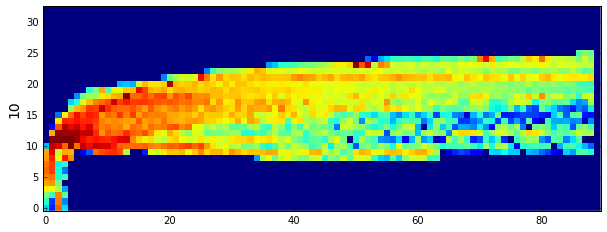

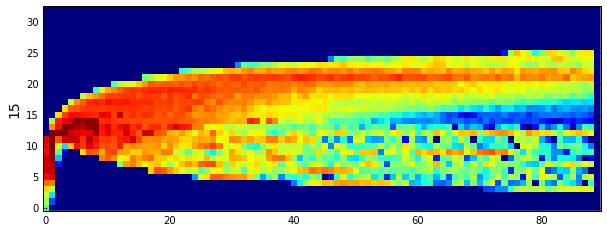

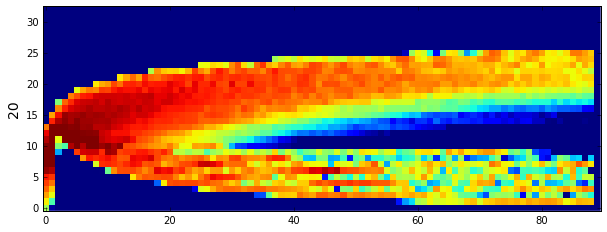

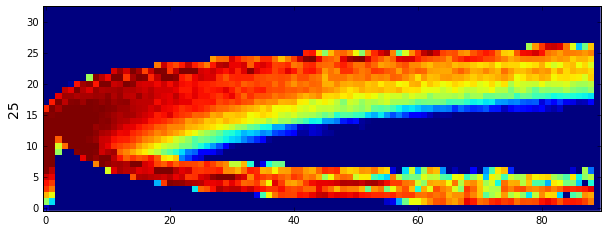

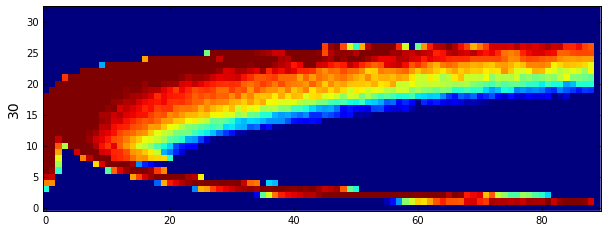

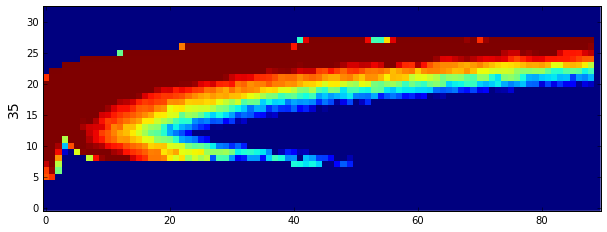

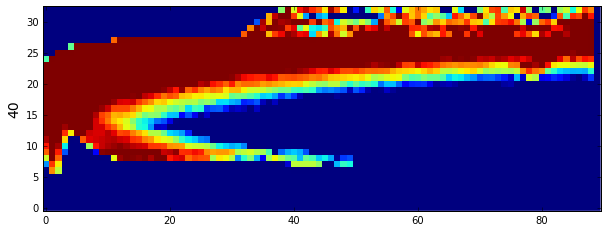

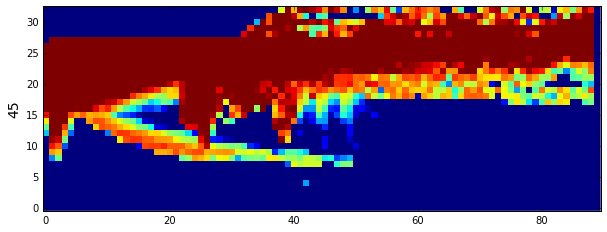

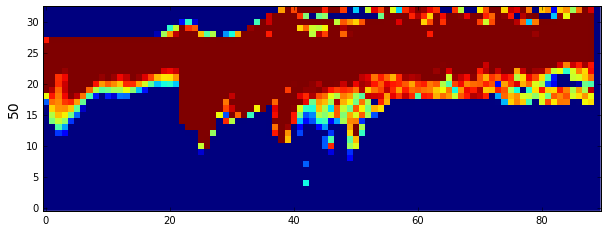

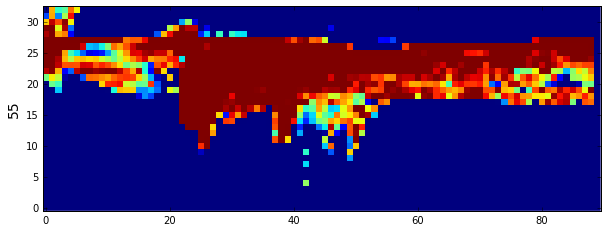

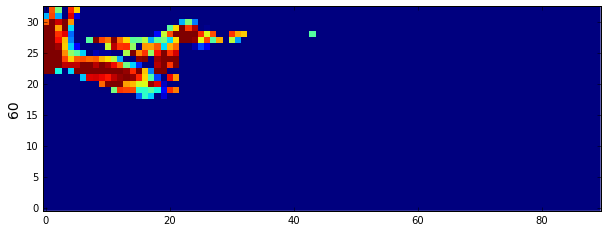

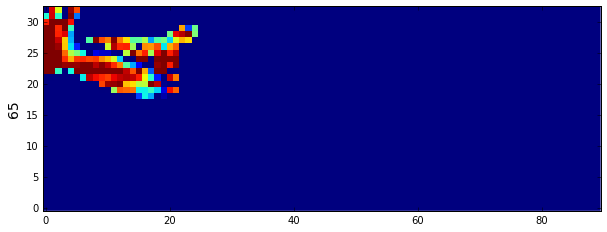

In [463]:
import pickle

with open("db_test.pkl",'r') as file:
    db = pickle.load(file)

    
print db['in_lats']

clims = [-3,2]
for il_ind, il_val in enumerate(db['in_lats']):
    data = db['N_el'][il_ind,:,:]
    print "N ranges: ",np.min(data), np.max(data)
    plt.figure()
    
    Nv = np.log10(data)
    Nv = np.clip(Nv,clims[0],clims[1])
    plt.imshow(Nv,origin='lower',interpolation='none')
    plt.clim(clims)
    plt.ylabel(il_val)





0 (0, 10)
1 (10, 20)
2 (20, 30)
3 (30, 40)
4 (40, 50)
5 (50, 60)
6 (60, 70)
7 (70, 80)
8 (80, 90)
9 (90, 100)
10 (100, 110)
11 (110, 120)
12 (120, 130)
13 (130, 140)
14 (140, 150)
15 (150, 160)
16 (160, 170)
17 (170, 180)
18 (180, 190)
19 (190, 200)
20 (200, 210)
21 (210, 220)
22 (220, 230)
23 (230, 240)
24 (240, 250)
25 (250, 260)
26 (260, 270)
27 (270, 280)
28 (280, 290)
29 (290, 300)
30 (300, 310)
31 (310, 320)
32 (320, 330)
33 (330, 340)
34 (340, 350)
35 (350, 360)
36 (360, 370)
37 (370, 380)
38 (380, 390)
39 (390, 400)
40 (400, 410)
41 (410, 420)
42 (420, 430)
43 (430, 440)
44 (440, 450)
45 (450, 460)
46 (460, 470)
47 (470, 480)
48 (480, 490)
49 (490, 500)
50 (500, 510)
51 (510, 520)
52 (520, 530)
53 (530, 540)
54 (540, 550)
55 (550, 560)
56 (560, 570)
57 (570, 580)
58 (580, 590)
59 (590, 600)
60 (600, 610)
61 (610, 620)
62 (620, 630)
63 (630, 640)
64 (640, 650)
65 (650, 660)
66 (660, 670)
67 (670, 680)
68 (680, 690)
69 (690, 700)
70 (700, 710)
71 (710, 720)
72 (720, 730)
73 (730,

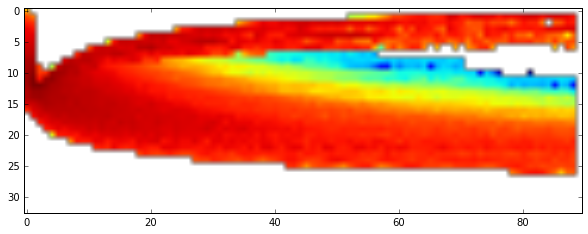

In [241]:
# Let's downsample the things!


new_step = 0.5  # seconds
t = db[in_lats[0]]['t']


t_new = np.arange(0,T_MAX, step=new_step) # New time vector
intervals = np.round(t_new*NUM_STEPS/T_MAX).astype(int) # Intervals to sum between

# print t[intervals]
# t = db[in_lats[0]]['t']


in_tmp = N_arr[3,:,:]
out_tmp= np.zeros([len(in_lats),len(L_vec), len(t_new)])

for ind, Tp in enumerate(zip(intervals[0:], intervals[1:])):
    print ind, Tp
    out_tmp[3,:,ind] = np.sum(N_arr[3,:,Tp[0]:Tp[1]],axis=1)

plt.imshow(np.log10(out_tmp[3,:,:]))

(20, 320, 90)


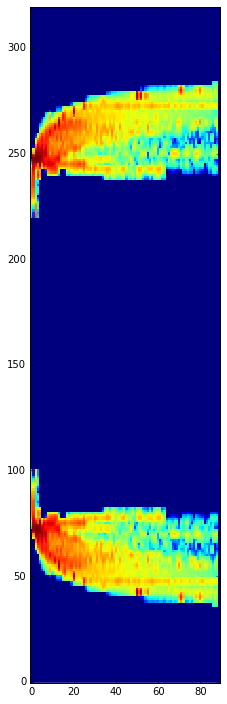

In [579]:
from precip_model import precip_model

p = precip_model(database="db_test.pkl")

lat_targ = np.arange(-80,80,step=0.5)
in_lat_targ = np.arange(-50,50,step=5)
t = p.t


interp_d = p.get_multiple_precip_at(in_lat_targ, lat_targ, t)

# tx, ty, tz = np.meshgrid(in_lat_targ, lat_targ, t)

# keys =  np.array([np.abs(tx.ravel()),np.abs(ty.ravel()), tz.ravel()]).T
# use_southern_hemi = np.array(((tx > 0) ^ (ty > 0)).ravel())

# print np.shape(keys)
# print np.shape(use_southern_hemi)

# keys_N = keys[~use_southern_hemi,:]
# keys_S = keys[ use_southern_hemi,:]

# out_data = np.zeros([len(in_lat_targ)*len(lat_targ)*len(t)])
# out_data[ use_southern_hemi] = p.S_interp(keys_S)
# out_data[~use_southern_hemi] = p.N_interp(keys_N)

# interp_d = out_data.reshape(len(lat_targ),len(in_lat_targ),len(t)).swapaxes(0,1)

print np.shape(interp_d)
# # print np.shape(tmp)
# use_southern_hemi = (tx > 0) ^ (ty > 0)
# print use_southern_hemi
# # print tmp
# interp_d = p.N_interp(keys).reshape(len(lat_targ),len(in_lat_targ),len(t)).swapaxes(0,1)
# # print np.shape(interp_d)

plt.figure()
# plt.plot(interp_d)
Nv = np.log10(interp_d[-8,:,:])
Nv = np.clip(Nv,clims[0],clims[1])
plt.imshow(Nv,origin='lower',interpolation='none')
plt.clim(clims)
